In [1]:
import os
import pandas as pd
import numpy as np
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import seaborn as sns

# prophet
from fbprophet import Prophet
# arima
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# Data load

In [2]:
DATASET_PATH = os.path.join('/USER/team_project2/data')

In [3]:
train_df = pd.read_csv(os.path.join(DATASET_PATH, 'train.csv'))

In [ ]:
val_df = pd.read_csv(os.path.join(DATASET_PATH, 'validate.csv'))

In [ ]:
test_df = pd.read_csv(os.path.join(DATASET_PATH, 'test.csv'))

In [6]:
submission_df = pd.read_csv(os.path.join(DATASET_PATH, 'sample_submission.csv'))

In [7]:
train_df

,날짜,시간,10,100,101,120,121,140,150,160,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200101,0,83247,19128,2611,5161,1588,892,32263,1636,...,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,20200101,1,89309,19027,3337,5502,1650,1043,35609,1644,...,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,20200101,2,66611,14710,2970,4631,1044,921,26821,1104,...,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,20200101,3,53290,13753,2270,4242,1021,790,21322,909,...,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,20200101,4,52095,17615,2406,3689,1840,922,22711,1354,...,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,20200517,19,311727,101285,10085,30637,10060,8749,148935,6801,...,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3275,20200517,20,305354,91426,8607,26021,8095,7198,136503,6147,...,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3276,20200517,21,306008,75113,6325,19933,5711,4494,129412,5134,...,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3277,20200517,22,237447,49498,4209,12145,3891,2718,96698,3526,...,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


# Data 전처리

### 1월 25일 평균값으로 대체

In [ ]:
mean_pd = []
for i in range(24):
    zero = train_df[train_df['시간']==int(i)]
    mean = zero.mean().astype('int')
    mean_pd.append(mean)
mean_df = pd.DataFrame(mean_pd)
mean_df['날짜']=20200125 # train data 도로별 시간대별 평균 dataframe

In [ ]:
mean_df

### 날짜,시간 columns 병합

In [8]:
train_df['시간'] = train_df['시간'].astype('str')

In [9]:
train_df['날짜'] = train_df['날짜'] + train_df['시간']

In [10]:
train_df = train_df.drop("시간", axis=1)

In [11]:
train_df

,날짜,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,202001010,83247,19128,2611,5161,1588,892,32263,1636,7938,...,1311,3482,11299,7072,1176,3810,748,3920,2133,3799
1,202001011,89309,19027,3337,5502,1650,1043,35609,1644,9896,...,1162,3849,13180,8771,1283,3763,782,3483,2057,4010
2,202001012,66611,14710,2970,4631,1044,921,26821,1104,9343,...,768,2299,7986,5426,1536,3229,491,2634,1526,3388
3,202001013,53290,13753,2270,4242,1021,790,21322,909,10009,...,632,1716,5703,3156,1104,2882,431,2488,1268,3686
4,202001014,52095,17615,2406,3689,1840,922,22711,1354,15497,...,875,2421,5816,2933,1206,2433,499,2952,1927,5608
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3274,2020051719,311727,101285,10085,30637,10060,8749,148935,6801,26101,...,6726,15431,25597,14292,9300,22238,3786,16936,10729,20194
3275,2020051720,305354,91426,8607,26021,8095,7198,136503,6147,20759,...,5501,15378,24661,14747,8239,20604,3203,15018,9767,17962
3276,2020051721,306008,75113,6325,19933,5711,4494,129412,5134,14496,...,4216,12558,22781,14081,6392,17937,2447,12403,7825,14031
3277,2020051722,237447,49498,4209,12145,3891,2718,96698,3526,9363,...,2578,8870,16640,11066,4427,11955,1495,7507,5387,8889


### Datetime으로 변환

In [14]:
train_df['날짜']=train_df['날짜'].apply(lambda _ : datetime.strptime(_,'%Y%m%d%H'))

In [ ]:
val_df['날짜'] = val_df['날짜'].astype('str')
val_df['시간'] = val_df['시간'].astype('str')
val_df['날짜'] = val_df['날짜'] + val_df['시간']
val_df = val_df.drop("시간", axis=1)
val_df['날짜']=val_df['날짜'].apply(lambda _ : datetime.strptime(_,'%Y%m%d%H'))

In [ ]:
test_df['날짜'] = test_df['날짜'].astype('str')
test_df['시간'] = test_df['시간'].astype('str')
test_df['날짜'] = test_df['날짜'] + test_df['시간']
test_df = test_df.drop("시간", axis=1)
test_df['날짜']=test_df['날짜'].apply(lambda _ : datetime.strptime(_,'%Y%m%d%H'))

### train data에 validation, test데이터 추가

In [ ]:
s_test_df = test_df[:168] #일부 DataFrame 추출
s_test_df

In [ ]:
train_df = pd.concat([train_df, val_df ,s_test_df]) # train + val + test
train_df

# Prophet 모델학습(10번 도로만 Test)

In [23]:
train_df2 = train_df[['날짜','10']] #10번도로 추출

In [25]:
train_df2.columns = ['ds','y']

In [26]:
model = Prophet()

In [27]:
model.fit(train_df2)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -141.231


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7111.31    0.00159191       325.441      0.9087      0.9087      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7120.65     0.0151125       607.119           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       7123.08   0.000108578       126.264    7.18e-07       0.001      317  LS failed, Hessian reset 
     299       7124.18   0.000669176       95.9236      0.7428      0.7428      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7125.37   7.03839e-05       53.7414      0.7892      0.7892      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     460        7126.1   0.000180513       103.876   4.328e-07       0.001      6

### Visualization

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


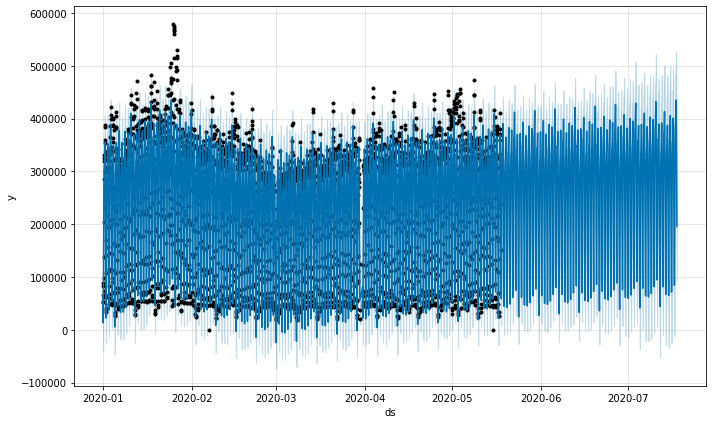

In [28]:
future = model.make_future_dataframe(periods = 1464, freq = 'H')
fcst = model.predict(future)
fig = model.plot(fcst)

In [34]:
fcst

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-01 00:00:00,218020.048702,12460.683465,115249.897997,218020.048702,218020.048702,-151550.666423,-151550.666423,-151550.666423,-141490.096711,-141490.096711,-141490.096711,-10060.569712,-10060.569712,-10060.569712,0.0,0.0,0.0,66469.382279
1,2020-01-01 01:00:00,218140.383714,-16953.563314,88299.497702,218140.383714,218140.383714,-185018.570962,-185018.570962,-185018.570962,-176032.786756,-176032.786756,-176032.786756,-8985.784206,-8985.784206,-8985.784206,0.0,0.0,0.0,33121.812752
2,2020-01-01 02:00:00,218260.718725,-38438.658089,63935.869272,218260.718725,218260.718725,-205000.793856,-205000.793856,-205000.793856,-197110.555484,-197110.555484,-197110.555484,-7890.238372,-7890.238372,-7890.238372,0.0,0.0,0.0,13259.924869
3,2020-01-01 03:00:00,218381.053737,-32106.641938,72146.963155,218381.053737,218381.053737,-200618.877538,-200618.877538,-200618.877538,-193828.670361,-193828.670361,-193828.670361,-6790.207177,-6790.207177,-6790.207177,0.0,0.0,0.0,17762.176199
4,2020-01-01 04:00:00,218501.388748,-721.429028,105177.311748,218501.388748,218501.388748,-167104.534971,-167104.534971,-167104.534971,-161402.868337,-161402.868337,-161402.868337,-5701.666634,-5701.666634,-5701.666634,0.0,0.0,0.0,51396.853777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4738,2020-07-17 19:00:00,271168.155908,259711.304828,461897.039715,187394.978511,353607.600633,92301.510801,92301.510801,92301.510801,61641.601781,61641.601781,61641.601781,30659.909019,30659.909019,30659.909019,0.0,0.0,0.0,363469.666709
4739,2020-07-17 20:00:00,271185.037584,220311.895172,413631.105195,187283.686230,353710.653787,47763.367671,47763.367671,47763.367671,17495.304860,17495.304860,17495.304860,30268.062811,30268.062811,30268.062811,0.0,0.0,0.0,318948.405255
4740,2020-07-17 21:00:00,271201.919260,178518.311968,369182.457797,187178.665058,353813.706941,4148.267540,4148.267540,4148.267540,-25490.097838,-25490.097838,-25490.097838,29638.365378,29638.365378,29638.365378,0.0,0.0,0.0,275350.186800
4741,2020-07-17 22:00:00,271218.800936,134358.858858,337848.401506,187075.057346,353916.760095,-36321.642616,-36321.642616,-36321.642616,-65093.634253,-65093.634253,-65093.634253,28771.991637,28771.991637,28771.991637,0.0,0.0,0.0,234897.158320


### 예측데이터 확인

In [45]:
pred = fcst.query("ds >= '2020-05-25' and ds <='2020-05-31 23:00'")
pred_yhat = pred.loc[:,["ds","yhat"]]

In [ ]:
pred_df = fcst.iloc[3447:3615]
pred_yhat = pred_df.loc[:,["ds","yhat"]]

In [93]:
pred_df # yhat이 Prophet모델에서의 예측값이다.

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
3447,2020-05-25 00:00:00,249373.912272,62948.168529,161605.551392,246495.636093,252373.141845,-135430.692109,-135430.692109,-135430.692109,-141490.096711,-141490.096711,-141490.096711,6059.404602,6059.404602,6059.404602,0.0,0.0,0.0,113943.220163
3448,2020-05-25 01:00:00,249390.793948,31701.452869,133750.941586,246490.772068,252417.400583,-168289.726366,-168289.726366,-168289.726366,-176032.786756,-176032.786756,-176032.786756,7743.060390,7743.060390,7743.060390,0.0,0.0,0.0,81101.067582
3449,2020-05-25 02:00:00,249407.675624,11144.085197,113457.444880,246485.908044,252472.010242,-187840.428170,-187840.428170,-187840.428170,-197110.555484,-197110.555484,-197110.555484,9270.127314,9270.127314,9270.127314,0.0,0.0,0.0,61567.247454
3450,2020-05-25 03:00:00,249424.557300,15815.775707,116852.459698,246481.044020,252514.404671,-183202.879623,-183202.879623,-183202.879623,-193828.670362,-193828.670362,-193828.670362,10625.790739,10625.790739,10625.790739,0.0,0.0,0.0,66221.677677
3451,2020-05-25 04:00:00,249441.438976,45832.680004,150258.748340,246467.513546,252555.772387,-149605.469198,-149605.469198,-149605.469198,-161402.868337,-161402.868337,-161402.868337,11797.399139,11797.399139,11797.399139,0.0,0.0,0.0,99835.969778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3610,2020-05-31 19:00:00,252125.625450,254870.611035,363905.707082,243663.173634,261244.984717,57582.599875,57582.599875,57582.599875,61641.601780,61641.601780,61641.601780,-4059.001905,-4059.001905,-4059.001905,0.0,0.0,0.0,309708.225326
3611,2020-05-31 20:00:00,252142.507126,216328.295071,320474.738261,243644.717016,261306.801453,15616.983430,15616.983430,15616.983430,17495.304860,17495.304860,17495.304860,-1878.321430,-1878.321430,-1878.321430,0.0,0.0,0.0,267759.490556
3612,2020-05-31 21:00:00,252159.388802,175494.272185,278403.361551,243616.209834,261361.448943,-25243.972967,-25243.972967,-25243.972967,-25490.097838,-25490.097838,-25490.097838,246.124872,246.124872,246.124872,0.0,0.0,0.0,226915.415835
3613,2020-05-31 22:00:00,252176.270478,134964.527183,238987.381451,243587.702652,261403.869568,-62802.172676,-62802.172676,-62802.172676,-65093.634253,-65093.634253,-65093.634253,2291.461578,2291.461578,2291.461578,0.0,0.0,0.0,189374.097802


# Prophet 모델 학습(전체 도로)

In [102]:
for col in submission_df.columns[1:]:              # submission_df의 timestamp열을 제외하고 모두 제거
    submission_df = submission_df.drop(col, axis=1)

for col in train_df.columns[1:].tolist():          # 각각의 도로별로 나누어, model fit시킨다.
    train_df2 = train_df[['날짜',col]]
    train_df2.columns = ['ds','y']
    
    model = Prophet()      
    model.fit(train_df2)   # 모델 fit
    
    future = model.make_future_dataframe(periods = 1464, freq = 'H')     # predict
    forecast = model.predict(future)
    print(f'{col} Forecasting....')
    
    pred_df = forecast.iloc[3447:3615]                    # 예측값에 해당하는 날짜 df
    pred_yhat = pred_df.loc[:,["ds","yhat"]]              # df에서 날짜와 예측값만 추출
    pred_yhat = pred_yhat[["yhat"]]                       
    pred_yhat = pred_yhat.reset_index()                   # 예측값의 index를 초기화
    pred = pred_yhat.drop(["index"], axis=1)
    pred.rename(columns = {"yhat":col},inplace=True)      # index열을 삭제한뒤, yhat컬럼명을 각 도로명으로 변경
    
    submission_df = pd.concat([submission_df, pred], axis = 1)     #submission_df에 timestamp옆에 각 도로별 예측값을 합쳐준다.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -141.231
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7111.31    0.00159191       325.441      0.9087      0.9087      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7120.65     0.0151125       607.119           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       7123.08   0.000108578       126.264    7.18e-07       0.001      317  LS failed, Hessian reset 
     299       7124.18   0.000669176       95.9236      0.7428      0.7428      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7125.37   7.03839e-05       53.7414      0.7892      0.7892      533   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     460        7126.1   0.000180513    

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


10 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -149.186
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7075.52     0.0082706       403.745           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       7079.16   0.000160482       165.005   8.679e-07       0.001      264  LS failed, Hessian reset 
     199       7079.34    0.00177834       102.104           1           1      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7080.03   0.000589739       78.9996      0.8854      0.8854      408   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7080.58   6.93582e-05        77.669      0.7297      0.7297      534   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     417       7080.61    0.00013624    

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


100 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -43.1592
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7773.49     0.0018962       234.557      0.3109      0.3109      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       7781.31   7.52953e-05       121.981   4.288e-07       0.001      253  LS failed, Hessian reset 
     199       7782.29    0.00240265       129.183           1           1      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       7783.01   8.16724e-05       109.723   3.351e-07       0.001      345  LS failed, Hessian reset 
     292       7785.28   0.000116291       153.507   1.181e-06       0.001      503  LS failed, Hessian reset 
     299        7785.6    0.00309247       514.396           1           1      510   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


101 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -40.657
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7921.46    0.00376728       711.412      0.8103      0.8103      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       7930.44   4.59901e-05       79.7562    3.55e-07       0.001      260  LS failed, Hessian reset 
     199       7930.66   0.000286043       100.559      0.4208      0.4208      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     259       7932.45   7.41395e-05       136.295   5.435e-07       0.001      409  LS failed, Hessian reset 
     299       7933.09   0.000485091       59.5228      0.2956      0.2956      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7933.42   2.45566e-05       73.9421      0.6885      0.6885      591   
    Iter      log prob

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


120 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -129.844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6828.49   0.000339723       175.614      0.5831      0.5831      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158        6830.2   0.000154584       97.9917   2.044e-06       0.001      234  LS failed, Hessian reset 
     199       6830.28   5.49727e-05       56.2546      0.4179           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       6830.31   3.02182e-07       75.5385      0.1435      0.6207      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
121 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -67.2071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7271.27     0.0154483       129.631           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       7274.33   0.000131867       104.311   4.308e-07       0.001      191  LS failed, Hessian reset 
     168       7276.17   0.000539548       229.791   3.724e-06       0.001      284  LS failed, Hessian reset 
     199       7276.79   0.000978884       167.029      0.2101           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7279.36   0.000265355       52.3345           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     345       7279.47   8.22879e-05       106.047   1.104e-06       0.001      559  LS failed, Hessian rese

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


140 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -126.288
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6937.18   0.000463972       367.406      0.6942      0.6942      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6949.75     0.0135964       141.776           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       6952.41   0.000139317       140.854    1.39e-06       0.001      354  LS failed, Hessian reset 
     299       6953.27   0.000159929       60.3762      0.6438      0.6438      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6955.34    0.00247738       97.6055           1           1      554   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6956.01   3.93612e-05    

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


150 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -126.095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7027.64     0.0106567       262.445           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       7032.12   0.000159388       152.672   1.626e-06       0.001      287  LS failed, Hessian reset 
     199       7032.16   2.53898e-05       68.6017       0.535       0.535      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       7032.16   3.36259e-07       72.4659      0.5301           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


160 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -70.3652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6601.29   0.000195743       161.536      0.1974      0.1974      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6604.99    0.00177617       111.008           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       6605.76   0.000130556       94.6175   7.439e-07       0.001      336  LS failed, Hessian reset 
     299       6606.51    0.00148458       153.067           1           1      406   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       6606.89   0.000184983       131.983   2.312e-06       0.001      480  LS failed, Hessian reset 
     378       6607.27   0.000100952       85.5737   7.617e-07       0.001      611  LS failed, Hessian rese

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


200 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -52.0797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7768.22     0.0279853       645.769           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7777.48   0.000257077       99.1056       0.513       0.513      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243        7778.6   0.000161935       212.158   1.036e-06       0.001      347  LS failed, Hessian reset 
     299       7779.36   0.000139752       70.1567           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       7779.37   0.000185112        73.401   2.052e-06       0.001      458  LS failed, Hessian reset 
     354       7780.07   9.13525e-05       115.771   3.313e-07       0.001      563  LS failed, Hessian rese

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


201 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -107.56
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7287.1    0.00641892       216.136           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7302.21    0.00408003       126.134           1           1      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        7305.4    0.00177773       130.803           1           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305       7305.47    8.4069e-05       107.262   7.246e-07       0.001      415  LS failed, Hessian reset 
     346       7305.55   2.06846e-07       61.9435      0.4774      0.4774      465   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


251 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -76.2234
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6970.32    0.00236813       583.517      0.1119           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       6980.54   7.97352e-05        67.976   5.516e-07       0.001      227  LS failed, Hessian reset 
     199       6983.27     0.0178299       84.5624           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243        6985.1    0.00010437       100.886   5.368e-07       0.001      398  LS failed, Hessian reset 
     299       6985.39     0.0165063       391.466           1           1      474   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6988.85   0.000490681       183.963      0.3154      0.3154      600   
    Iter      log pro

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


270 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -44.7027
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7136.58   0.000714615       447.806      0.6811      0.6811      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7142.34    0.00272037       169.401     0.08527     0.08527      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     288       7144.22   8.28696e-05       94.6107   7.307e-07       0.001      388  LS failed, Hessian reset 
     299       7144.42   0.000558693       105.443      0.3819           1      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       7145.34    0.00019676       90.4113      0.2782      0.2782      529   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     471       7146.58   9.87449e-05    

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


300 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -85.2043
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6761.42    0.00809042       208.464           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6765.23     0.0083996       194.754           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299        6767.2   0.000560057        103.35      0.6666      0.6666      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     322       6767.56   9.51277e-05       66.4819   6.116e-07       0.001      438  LS failed, Hessian reset 
     399       6767.86   7.46534e-06       59.2188      0.4743           1      553   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     426       6767.87   3.27735e-07    

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


301 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -63.1118
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6984.54    0.00347766       339.503      0.5407      0.5407      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6989.35    0.00100235       121.126           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     269       6991.02   9.55883e-05        95.199   6.343e-07       0.001      380  LS failed, Hessian reset 
     299        6991.1    1.6454e-05       56.6221           1           1      418   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6993.94   0.000247553       278.849      0.1924      0.1924      536   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499       6995.87   0.000252464    

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


351 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -159.87
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6606.42     0.0045523       123.726           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       6610.48   0.000126994       105.128   9.095e-07       0.001      206  LS failed, Hessian reset 
     199       6613.06    0.00125956       277.794   1.842e-05       0.001      342  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6613.59    0.00185706       63.9264           1           1      470   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6615.34   0.000613573       62.6879       3.144      0.3144      598   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       66

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


352 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -183.866
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6276.74    0.00114493       191.892           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       6277.45   0.000326284       175.333   3.526e-06       0.001      171  LS failed, Hessian reset 
     169       6278.95   0.000191604       140.106   1.954e-06       0.001      291  LS failed, Hessian reset 
     199        6279.5   0.000232544       71.1328           1           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       6279.51   8.49151e-05       49.6947   9.955e-07       0.001      397  LS failed, Hessian reset 
     241       6279.52   1.34383e-07       59.4245      0.1564      0.6653      428   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


370 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -127.387
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6875.48    0.00271474       107.343      0.0362      0.4012      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6880.41   0.000676946       63.3066           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242          6881   0.000136529        109.34    5.92e-07       0.001      348  LS failed, Hessian reset 
     299       6881.58   2.80194e-06       57.5499           1           1      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     356       6881.97   0.000140509       89.2093   5.425e-07       0.001      548  LS failed, Hessian reset 
     380       6882.59   0.000581232       129.177   7.885e-06       0.001      614  LS failed, Hessian rese

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


400 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -86.6467
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7297.5     0.0245982       162.468           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7307.77   0.000317628       106.321      0.1892      0.9522      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       7310.56   7.71999e-05       101.954   7.301e-07       0.001      413  LS failed, Hessian reset 
     299       7310.57   0.000115375       58.7443           1           1      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       7310.67   0.000101379       103.738   1.391e-06       0.001      477  LS failed, Hessian reset 
     347       7310.71   1.17744e-05       71.5769   1.807e-07       0.001      556  LS failed, Hessian rese

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


450 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -115.528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       7050.34    0.00203902        142.88       0.521           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       7055.52   0.000300043       79.1549           1           1      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7055.78   4.29053e-06       69.5176      0.4597      0.4597      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     331       7055.78   4.32801e-07       68.6807       0.197           1      411   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


500 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -70.5063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6915.44     0.0105514       312.228           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       6924.61    0.00016266       154.565   6.677e-07       0.001      208  LS failed, Hessian reset 
     199       6930.12   0.000415586       72.0291           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       6931.69   0.000525627       240.821   3.655e-06       0.001      390  LS failed, Hessian reset 
     290       6933.53   0.000115639       112.951   6.227e-07       0.001      503  LS failed, Hessian reset 
     299       6933.67   0.000580553       75.8454        3.42      0.7623      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


550 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -70.1942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6253.61   0.000190586       63.0209      0.8527      0.8527      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       6254.04    0.00180086       189.708   2.458e-05       0.001      189  LS failed, Hessian reset 
     156        6254.2   0.000106213       95.5119   1.255e-06       0.001      269  LS failed, Hessian reset 
     199       6254.23   2.22287e-06       70.6165      0.3603      0.3603      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       6254.23   8.59807e-06       75.9317   1.096e-07       0.001      386  LS failed, Hessian reset 
     247       6254.23   1.16649e-06       56.6263      0.5249      0.5249      433   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -59.1701
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6930.95    0.00501008       107.319           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6934.36    0.00018228       92.3743           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6937.51    0.00598553       219.334           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       6938.01   0.000116885       115.021   7.538e-07       0.001      431  LS failed, Hessian reset 
     399       6938.88   1.52604e-06       71.2091      0.4003      0.4003      552   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     431       6938.91   8.59203e-05    

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


650 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -46.8704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        7766.1     0.0113809       172.555           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       7768.05   0.000213761       179.382   2.851e-06       0.001      239  LS failed, Hessian reset 
     199       7768.19   0.000250564        88.269           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       7768.99     0.0105859       139.406      0.6077           1      411   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     370       7769.39   5.66952e-07       88.9819      0.5907      0.5907      502   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


652 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -250.227
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6203.33   7.58594e-05       67.9327      0.2124           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       6203.37   0.000134825          90.7   1.603e-06       0.001      182  LS failed, Hessian reset 
     128       6203.39   8.29644e-05       68.7934   1.474e-06       0.001      239  LS failed, Hessian reset 
     146       6203.39   2.56765e-07       59.0912      0.3325           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1000 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -107.379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6579.12    0.00191657       236.926           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       6582.36   0.000796467       87.8485      0.3896           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       6582.46   0.000175916       144.313   1.742e-06       0.001      306  LS failed, Hessian reset 
     271       6582.52   4.66775e-05       82.3535   5.655e-07       0.001      425  LS failed, Hessian reset 
     299       6582.53   1.52247e-06       80.8227      0.8644      0.8644      459   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       6582.54    1.0375e-05       77.9328   1.154e-07       0.001      540  LS failed, Hessian rese

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1020 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -203.253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6726.58    0.00593894       186.719           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       6727.04   0.000240747       81.1776   3.116e-06       0.001      237  LS failed, Hessian reset 
     199       6727.12     3.587e-05       82.4408           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       6727.89   0.000126408       114.774   9.044e-07       0.001      386  LS failed, Hessian reset 
     263       6727.98    3.6527e-05       85.5544   4.492e-07       0.001      467  LS failed, Hessian reset 
     299       6727.98   2.44835e-06       71.8866      0.2984           1      515   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1040 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -146.143
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6423.62   0.000300558       214.279       0.231       0.231      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       6424.92   0.000224112       145.773   2.672e-06       0.001      247  LS failed, Hessian reset 
     199       6425.46    0.00734572       120.357      0.8795      0.8795      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       6425.63   0.000114276       86.9241   9.924e-07       0.001      375  LS failed, Hessian reset 
     299       6425.87    0.00221453       133.508           1           1      493   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       6426.04   3.62251e-05       59.0019      0.4503      0.4503      622   
    Iter      log pro

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1100 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -130.651
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6594.11   0.000595339       81.1483      0.2797           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       6594.46   8.41762e-05       82.4323   9.355e-07       0.001      245  LS failed, Hessian reset 
     199       6594.54   4.15874e-05        77.206           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       6594.56   0.000104622       89.7528   1.123e-06       0.001      362  LS failed, Hessian reset 
     248       6594.56   1.46629e-07       68.4759      0.1262      0.6149      397   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1200 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -55.3004
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6490.83    0.00249965       336.242      0.2556      0.2556      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       6502.43   0.000146695        91.183    2.35e-06       0.001      276  LS failed, Hessian reset 
     199        6502.5   0.000905849       94.1556           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       6506.97     0.0082102       109.543      0.8355      0.8355      426   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303       6507.18   0.000253025       179.164   1.559e-06       0.001      477  LS failed, Hessian reset 
     399        6509.5     0.0351907        175.96           1           1      592   
    Iter      log pro

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


1510 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -142.913
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6417.92    0.00641275       144.413           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       6422.69   0.000308071       160.142   7.519e-07       0.001      236  LS failed, Hessian reset 
     199       6423.79   5.51106e-05       72.3156           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246        6424.1   0.000137283       83.3646   7.841e-07       0.001      392  LS failed, Hessian reset 
     287       6424.32   0.000181172       78.2469   2.242e-06       0.001      481  LS failed, Hessian reset 
     299       6424.32   4.40792e-06       81.7951      0.3477           1      496   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


2510 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -96.8446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6275.31    0.00949696       440.664      0.1532           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       6284.13   0.000313626       190.971   2.898e-06       0.001      267  LS failed, Hessian reset 
     199       6285.13    0.00020778       50.3454      0.3555           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       6285.28   0.000113203       89.8174   1.378e-06       0.001      355  LS failed, Hessian reset 
     294       6285.61    8.7056e-05        69.989   1.093e-06       0.001      501  LS failed, Hessian reset 
     299       6285.63   0.000109108       84.1514      0.9264      0.9264      506   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


3000 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -148.299
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6626.44    0.00367965       156.208           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       6630.81   0.000211816        148.49   1.628e-06       0.001      283  LS failed, Hessian reset 
     199       6630.86   0.000435877       68.0478           1           1      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       6631.29   1.80822e-07       62.4235      0.3227      0.3227      389   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


4510 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -204.253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       6254.24   0.000701898        198.64   5.391e-06       0.001      155  LS failed, Hessian reset 
      99       6254.29   0.000305456       112.335           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       6255.78   0.000360175        188.85   3.511e-06       0.001      291  LS failed, Hessian reset 
     199       6256.14   5.69223e-05       65.2584      0.2897           1      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       6256.26   5.15902e-05       83.4075   6.049e-07       0.001      469  LS failed, Hessian reset 
     299       6256.34   9.60852e-06       62.6815           1           1      514   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


5510 Forecasting....


/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -219.909
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       6323.36    0.00302665       107.464           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       6323.45   0.000164492       78.4953   7.849e-07       0.001      166  LS failed, Hessian reset 
     119       6323.74   0.000275066        156.97   2.914e-06       0.001      233  LS failed, Hessian reset 
     185        6324.2   0.000286447       124.171   3.276e-06       0.001      370  LS failed, Hessian reset 
     199       6324.22   5.62146e-05       77.9654           1           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       6324.26   4.11352e-07       75.9032      0.2626      0.9145      460   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/conda/lib/python3.8/site-packages/fbprophet/forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


6000 Forecasting....


### 결과 저장

In [103]:
submission_df

,timestamp,10,100,101,120,121,140,150,160,200,...,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
0,20200525_0,113943.220163,28353.143937,3409.591884,10368.901023,2611.950097,2654.301064,50888.482337,1999.456548,7151.460485,...,2038.584212,4540.768711,10256.733903,4852.847425,3926.998492,8312.492292,836.348929,3426.951716,3153.974286,5053.268438
1,20200525_1,81101.067582,21694.833453,2838.407023,8966.926880,2064.872920,2337.352703,37528.412626,1560.579218,6043.621382,...,1627.463375,3301.055838,6749.132713,2607.036764,3409.691141,7060.894905,719.386538,2693.286791,2496.046072,3962.184042
2,20200525_2,61567.247454,17619.910009,2447.918587,8284.936943,1379.357457,2031.281771,31255.350715,1238.379164,5317.632581,...,1155.231485,2391.041811,4068.608199,933.741499,3238.479069,6202.137772,440.871612,1527.663963,1785.073986,2918.299958
3,20200525_3,66221.677677,19542.471319,2505.904300,8601.088882,1089.865651,1940.395011,34989.762949,1242.950874,5310.031697,...,1014.032952,2588.838923,4942.196255,1136.242774,3352.485288,6193.094520,253.744544,1172.982296,1730.324770,3038.490613
4,20200525_4,99835.969778,29339.959929,3181.673000,9973.748374,1780.965606,2266.524965,48755.205851,1744.725968,6125.698831,...,1619.214920,4552.726384,11186.853242,4089.670481,3593.223919,7471.473846,494.035397,3076.452287,2961.265917,5238.540611
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,20200531_19,309708.225326,93075.450323,10465.409248,27878.195370,9731.379826,7810.016899,139610.241200,6330.245482,19966.155561,...,7484.965284,14866.330629,36551.825534,17128.532739,8942.004032,23092.068297,3548.629159,16009.099883,10818.075314,19277.541864
164,20200531_20,267759.490556,73422.895819,7942.228110,22201.729188,7094.515194,5972.478595,119733.604850,5025.696814,15786.027354,...,5428.421522,12389.092795,29606.688070,14626.982950,7647.159792,18649.667845,2483.411306,11630.686961,8011.403573,14090.368215
165,20200531_21,226915.415835,56836.408821,6075.363723,17968.524231,4924.753072,4497.583715,101783.471845,3917.015427,12474.682320,...,3807.374604,9777.499795,22492.161423,11718.108081,6627.773803,14882.483051,1520.281437,7488.774111,5668.969925,9802.774966
166,20200531_22,189374.097802,45248.120125,4950.235632,15145.227975,3639.571985,3598.561269,85242.115960,3128.276987,10290.296838,...,2880.508314,7613.324372,17173.151171,9125.403958,5773.681996,12177.913052,956.031603,4878.053139,4302.857635,7269.597345


In [104]:
submission_df.to_csv('prophet_pred.csv', index=False)